<a href="https://colab.research.google.com/github/evillag/xtol_m5/blob/master/T4/INA2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Módulo 5, Tarea 4: Proyecto Final**
## **Data Science with Python (XTOL - Cenfotec)**
## *Autor: Esteban  Villalobos*
## *2 de Abril, 2020*

**Base de datos:** "*Matrículas Neta TOTAL 2018*". Fuentes de datos: INEC, Costa Rica - Instituto Nacional de Aprendizaje: Servicios de Capacitación y Formación Profesional Ejecutados 2018, Generada por la Unidad de Planificación y Evaluación - Año 2018

La base contiene todas las matrículas de los servicios impartidos por el Instituto Nacional de Aprendizaje (INA), son servicios acumulados a la fecha de cierre, en este caso al 31/12/2018. Todos los servicios están dados en términos de la unidad básica común "módulo", es decir: módulos certificables o independientes, módulos que conforman un programa, asistencias técnicas y pruebas de certificación.

Son servicios finalizados, se incluye no solo la matrícula sino las calificaciones, así como los datos correspondientes al servicio una vez incluidas las calificaciones.

**Diccionario de Datos**: http://sistemas.inec.cr/pad4/index.php/catalog/219/datafile/F1

**Datos originales**:http://sistemas.inec.cr/pad4/index.php/catalog/219/download/2690 

**Variables**:70

**Cantidad de observaciones**: 300,578

**Existen nulos**: Sí

**Objetivo**: Utilizar la información existente de estudiantes que ya llevaron cursos y que tienen notas reportadas, para entrenar un modelo automático el cual pueda predecir si los estudiantes nuevos van a aprobar o reprobar los cursos que matriculen.
Esto puede permitir a la institución realizar proyecciones de existo/fracaso de los estudiantes de diferentes edades, genero, estudio, condición laboral y educativa, para así poder determinar las acciones se pueden realizar para aumentar la tasa de éxito estudiantil en los diferentes programas y/o cursos.


In [0]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame, CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

#model metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score

#regression estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
#classification estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [10.0, 8.0]

# Plot font sizes (source: https://stackoverflow.com/a/39566040/366771)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title




Los datos originales están en formato "SAV". Dichos datos fueron exportados a CSV para mayor facilidad de uso. Los datos son accesibles en el siguiente enlace de mi BitBucket personal: https://bitbucket.org/evillag/datasets/raw/2cd8d87491bf7c8a705939abeba737d2f670ef94/ina/MatriculasNetaTOTAL2018.csv

In [0]:
_file = 'https://bitbucket.org/evillag/datasets/raw/2cd8d87491bf7c8a705939abeba737d2f670ef94/ina/MatriculasNetaTOTAL2018.csv'
#_file = 'MatriculasNetaTOTAL2018.csv'
df = pd.read_csv(_file, index_col=0, header=0)
df.sample(15)

,tipunid,ANO,ANO_FIN,ANO_INI,CALIFICA,COD_MODUlo,COD_PROG,COD_PROVI,COD_SECTOR,COD_UNIDAD,Cualificacion,EDAD,EJE_AMBIENTE,EJE_EMPLEA,EJE_EMPREN,EJE_EQUIDAD,ESTA_CIVIL,ESTA_CURSO,ESTU_ACT,F_FIN_PROG,FEC_LIQUID,FECHA_FIN,FECHA_INI,JORNADA_CU,LLAVE,LUGAR,MOD_DISE,MOD_PROG,MODALIDAD,NV_ACADE,NOM_serv,NV_ACA_BACH,NV_ACA_COLTEC,PROV_EST,REFERENCIA,SEC_PROGrama,SECTOR,Nombre_programa,SEXO,SYS_EJEC,TIPO_INSTR,TIPO_TRA,TOTAL_HRS,TRABAJO,ZONA,tipo_modulo,TPSERVI,Modo,Cod_Subs_actualizada,Sececon,cantestu,cantonac,DISTRIAC,DISTESTU,q,nacional_extranjero,SUBSEC_PROGRAMA_actualizada,Sececon_PROGRAMA,LLave_unica,FECHA_APL,FECHA_ING,INA_participantes,INA_cod_sector_participantes,INA_cod_subsector_participantes,INA_tipunid_participantes,INA_cod_unid_participantes,INA_tipo_modulo_participantes,Area_prioritaria,sesecon_participantes,REGION2014
11368,2301,2018,2018.0,2018.0,85.0,ELTT0148,ELTT10002,2,9,2308,1.0,39,NaN,S,NaN,NaN,1,2,9,2018-04-25,2018-04-27,2018-04-25,2018-02-28,1.0,2308CPELTT1000212018ELTT0148,1.0,1.0,1.0,10.0,7,INTRODUCCION AL PROTOCOLO IPV6,3,3,1,2308CPELTT1000212018,9.0,4,INTRODUCCION AL PROTOCOLO IPV6,1,0.0,1.0,2,42.0,1,1.0,1,1.0,2.0,112,2,101,201,20102,10109,6,1,112.0,2.0,0,NaN,NaN,0,0,0,0,0,0,6.0,0,1.0
249549,2601,2018,2018.0,2018.0,97.0,AGGP0019,AGGP10008,2,1,2601,1.0,29,NaN,NaN,NaN,NaN,2,2,9,2018-11-23,2018-11-27,2018-11-23,2018-11-13,1.0,2601CPAGGP1000842018AGGP0019,2.0,1.0,1.0,14.0,5,FORMULACION Y EVALUACION DE PROYECTOS AGROPECU...,1,3,2,2601CPAGGP1000842018,1.0,0,FORMULACION Y EVALUACION DE PROYECTOS AGROPECU...,2,0.0,1.0,3,48.0,2,2.0,1,1.0,2.0,99,1,210,210,21013,21013,4,1,99.0,1.0,0,NaN,NaN,1,1,1,1,1,1,NaN,1,2.0
81964,2301,2018,2018.0,2018.0,0.0,CSTI0001,CSTI2024,2,11,2303,2.0,31,NaN,NaN,NaN,NaN,2,5,9,2018-06-22,2018-03-02,2018-03-02,2018-01-29,1.0,2303IFCSTI2024172018CSTI0001,1.0,4.0,4.0,15.0,3,INTRODUCCION A LA COMPUTACION,3,3,2,2303IFCSTI2024172018,11.0,0,OPERADOR(A) DE APLICACIONES OFIMÁTICAS,1,0.0,1.0,3,52.0,2,1.0,0,2.0,1.0,98,3,210,201,20101,21001,5,1,98.0,3.0,1,NaN,NaN,1,1,1,1,1,1,2.0,0,1.0
104098,2301,2018,2018.0,2018.0,96.0,CSTI0003,CSTI2024,2,11,2310,2.0,19,NaN,NaN,NaN,NaN,2,2,9,2018-08-22,2018-08-07,2018-08-06,2018-07-26,3.0,2310IFCSTI2024162018CSTI0003,1.0,4.0,4.0,10.0,5,PRESENTADOR GRAFICO POWER POINT,1,3,2,2310IFCSTI2024162018,11.0,0,OPERADOR(A) DE APLICACIONES OFIMÁTICAS,2,0.0,1.0,3,36.0,2,1.0,0,2.0,1.0,98,3,202,202,20201,20207,2,1,98.0,3.0,0,NaN,NaN,0,0,0,0,0,0,2.0,0,1.0
57761,2401,2017,2018.0,2017.0,73.0,CSID0054,CSID2012,1,11,2415,3.0,19,S,S,S,NaN,2,2,9,2018-08-16,2018-03-23,2018-03-21,2018-02-13,3.0,2415IFCSID201222017CSID0054,1.0,9.0,8.0,10.0,5,TECNICAS PARA LECTURA EN INGLES,1,3,1,2415IFCSID201222017,11.0,0,EJECUTIVO(A) EN INGLÉS PARA SERVICIOS,2,0.0,1.0,3,60.0,2,1.0,0,2.0,1.0,90,3,108,108,10805,10805,2,1,90.0,3.0,0,NaN,NaN,0,0,0,0,0,0,1.0,0,1.0
132736,2901,2017,2018.0,2017.0,85.0,CSID0016,CSID2005,4,11,2901,2.0,31,NaN,S,NaN,NaN,3,2,9,2018-03-19,2018-03-20,2018-03-19,2018-02-23,3.0,2901IFCSID2005132017CSID0016,2.0,9.0,9.0,10.0,6,INGLES AVANZADO,3,3,4,2901IFCSID2005132017,11.0,3,EJECUTIVO(A) EN INGLÉS PARA SERVICIOS,2,2.0,2.0,2,102.0,1,1.0,0,2.0,1.0,90,3,402,401,40101,40202,5,1,90.0,3.0,0,NaN,NaN,0,0,0,0,0,0,1.0,0,1.0
294259,2401,2016,2018.0,2016.0,98.0,ELRA0114,ELRA2028,1,9,2417,3.0,22,S,S,S,S,2,2,2,2018-04-02,2018-04-03,2018-04-02,2017-12-04,1.0,2417IFELRA202822016ELRA0114,1.0,10.0,9.0,10.0,4,PRACTICA DIDACTICA SUPERVISADA PARA TECNICOS E...,3,3,6,2417IFELRA202822016,9.0,3,MECANICO/A INSTALADOR/A DE REFRIGERACION Y CLI...,1,0.0,1.0,2,600.0,1,1.0,0,2.0,1.0,113,2,610,101,10107,61001,3,1,113.0,2.0,0,NaN,NaN,1,1,1,1,1,1,6.0,1,1.0
299553,2201,2018,2018.0,2018.0,86.0,CSPN0056,CSPN10004,5,11,2201,1.0,22,S,NaN,NaN,NaN,2,2,9,2018-10-03,2018-10-04,2018-10-03,2018-09-24,3.0,2201CPCSPN1000432018CSPN0056,2.0,1.0,1.0,14.0,4,PRIMEROS AUXILIOS BASICOS,3,3,5,2201CPCSPN1000432018,11.0,0,PRIMEROS AUXILIOS BASICOS,1,0.0,1.0,3,40.0,2,2.0,1,1.0,2.0,45,3,503,503,50304,50308,3,2,45.0,3.0,0,NaN,NaN,0,1,1,0,0,1,NaN,1,6.0


# Selección inicial de variables

In [0]:
#Borramos columnas pre-filtradas por el análisis del diccionario de datos
def drop_non_required_variables(data):
    data.drop(labels=['EDAD','F_FIN_PROG','Nombre_programa','REGION2014', 'COD_PROG','Area_prioritaria','F_FIN_PROG',
                      'COD_MODUlo','FEC_LIQUID','FECHA_FIN','FECHA_INI','LLAVE','MOD_DISE','MOD_PROG','NOM_serv',
                      'REFERENCIA','LLave_unica','FECHA_APL','FECHA_ING','INA_cod_sector_participantes',
                      'INA_cod_subsector_participantes','INA_tipunid_participantes','INA_cod_unid_participantes',
                      'INA_tipo_modulo_participantes','sesecon_participantes',], axis=1, inplace=True)

In [0]:
drop_non_required_variables(df)

## Revisión de valores faltantes.

In [0]:
df.isna().describe()

,tipunid,ANO,ANO_FIN,ANO_INI,CALIFICA,COD_PROVI,COD_SECTOR,COD_UNIDAD,Cualificacion,EJE_AMBIENTE,EJE_EMPLEA,EJE_EMPREN,EJE_EQUIDAD,ESTA_CIVIL,ESTA_CURSO,ESTU_ACT,JORNADA_CU,LUGAR,MODALIDAD,NV_ACADE,NV_ACA_BACH,NV_ACA_COLTEC,PROV_EST,SEC_PROGrama,SECTOR,SEXO,SYS_EJEC,TIPO_INSTR,TIPO_TRA,TOTAL_HRS,TRABAJO,ZONA,tipo_modulo,TPSERVI,Modo,Cod_Subs_actualizada,Sececon,cantestu,cantonac,DISTRIAC,DISTESTU,q,nacional_extranjero,SUBSEC_PROGRAMA_actualizada,Sececon_PROGRAMA,INA_participantes
count,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578,300578
unique,1,1,2,2,2,1,1,1,2,2,2,2,2,1,1,1,2,2,2,1,1,1,1,2,1,1,2,2,1,2,1,2,1,2,2,1,1,1,1,1,1,1,1,2,2,1
top,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,300578,300578,293161,293161,293161,300578,300578,300578,293161,168762,162336,179345,196201,300578,300578,300578,293161,293161,293161,300578,300578,300578,300578,293161,300578,300578,293161,293161,300578,293161,300578,293147,300578,293161,293161,300578,300578,300578,300578,300578,300578,300578,300578,293161,293161,300578


Las columnas de EJE_* contienen el valor 'S', si la temática del curso contempla el eje específico, y está vacío de lo contrario. Tiene sentido reemplazar los valores nulos con falso, o en este caso 0, y 'S' con 1.

In [0]:
def limpia_EJEs(data):
    data[['EJE_AMBIENTE', 'EJE_EMPLEA', 'EJE_EMPREN', 'EJE_EQUIDAD']] = data[['EJE_AMBIENTE',
                                                                      'EJE_EMPLEA',
                                                                      'EJE_EMPREN',
                                                                      'EJE_EQUIDAD']].fillna(0)
    data['EJE_AMBIENTE'].replace(['S'],[1], inplace=True)
    data['EJE_EMPLEA'].replace(['S'],[1], inplace=True)
    data['EJE_EMPREN'].replace(['S'],[1], inplace=True)
    data['EJE_EQUIDAD'].replace(['S'],[1], inplace=True)
    data[['EJE_AMBIENTE', 'EJE_EMPLEA', 'EJE_EMPREN', 'EJE_EQUIDAD']]

In [0]:
limpia_EJEs(df)

Un conteo de los valores nulos restantes muestra que corresponden a las mismas observaciones, y que son exactamente 7417. Dado que solo representan un 0.024 por ciento de las observaciones, vamos a eliminarlas.

In [0]:
for col in df.columns:
  print(f'{col}:\t{df[col].isna().sum()}')

tipunid:	0
ANO:	0
ANO_FIN:	7417
ANO_INI:	7417
CALIFICA:	7417
COD_PROVI:	0
COD_SECTOR:	0
COD_UNIDAD:	0
Cualificacion:	7417
EJE_AMBIENTE:	0
EJE_EMPLEA:	0
EJE_EMPREN:	0
EJE_EQUIDAD:	0
ESTA_CIVIL:	0
ESTA_CURSO:	0
ESTU_ACT:	0
JORNADA_CU:	7417
LUGAR:	7417
MODALIDAD:	7417
NV_ACADE:	0
NV_ACA_BACH:	0
NV_ACA_COLTEC:	0
PROV_EST:	0
SEC_PROGrama:	7417
SECTOR:	0
SEXO:	0
SYS_EJEC:	7417
TIPO_INSTR:	7417
TIPO_TRA:	0
TOTAL_HRS:	7417
TRABAJO:	0
ZONA:	7431
tipo_modulo:	0
TPSERVI:	7417
Modo:	7417
Cod_Subs_actualizada:	0
Sececon:	0
cantestu:	0
cantonac:	0
DISTRIAC:	0
DISTESTU:	0
q:	0
nacional_extranjero:	0
SUBSEC_PROGRAMA_actualizada:	7417
Sececon_PROGRAMA:	7417
INA_participantes:	0


In [0]:
df.dropna(inplace=True)
# Verificamos que ya no quedan NaNs en el dataframe.
for col in df.columns:
  print(f'{col}:\t{df[col].isna().sum()}')

tipunid:	0
ANO:	0
ANO_FIN:	0
ANO_INI:	0
CALIFICA:	0
COD_PROVI:	0
COD_SECTOR:	0
COD_UNIDAD:	0
Cualificacion:	0
EJE_AMBIENTE:	0
EJE_EMPLEA:	0
EJE_EMPREN:	0
EJE_EQUIDAD:	0
ESTA_CIVIL:	0
ESTA_CURSO:	0
ESTU_ACT:	0
JORNADA_CU:	0
LUGAR:	0
MODALIDAD:	0
NV_ACADE:	0
NV_ACA_BACH:	0
NV_ACA_COLTEC:	0
PROV_EST:	0
SEC_PROGrama:	0
SECTOR:	0
SEXO:	0
SYS_EJEC:	0
TIPO_INSTR:	0
TIPO_TRA:	0
TOTAL_HRS:	0
TRABAJO:	0
ZONA:	0
tipo_modulo:	0
TPSERVI:	0
Modo:	0
Cod_Subs_actualizada:	0
Sececon:	0
cantestu:	0
cantonac:	0
DISTRIAC:	0
DISTESTU:	0
q:	0
nacional_extranjero:	0
SUBSEC_PROGRAMA_actualizada:	0
Sececon_PROGRAMA:	0
INA_participantes:	0


Corrección del tipo de algunas columnas numéricas.

In [0]:
print(df.info())

convert_to_int64 = ['ANO_FIN', 'ANO_INI', 'Cualificacion', 'JORNADA_CU', 'LUGAR', 
                    'MODALIDAD', 'SEC_PROGrama', 'SYS_EJEC', 'TIPO_INSTR', 'ZONA',
                    'TPSERVI', 'Modo', 'SUBSEC_PROGRAMA_actualizada', 
                    'Sececon_PROGRAMA',]
for col in convert_to_int64:
  df[col] = df[col].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293147 entries, 1 to 300578
Data columns (total 46 columns):
tipunid                        293147 non-null int64
ANO                            293147 non-null int64
ANO_FIN                        293147 non-null float64
ANO_INI                        293147 non-null float64
CALIFICA                       293147 non-null float64
COD_PROVI                      293147 non-null int64
COD_SECTOR                     293147 non-null int64
COD_UNIDAD                     293147 non-null int64
Cualificacion                  293147 non-null float64
EJE_AMBIENTE                   293147 non-null int64
EJE_EMPLEA                     293147 non-null int64
EJE_EMPREN                     293147 non-null int64
EJE_EQUIDAD                    293147 non-null int64
ESTA_CIVIL                     293147 non-null int64
ESTA_CURSO                     293147 non-null int64
ESTU_ACT                       293147 non-null int64
JORNADA_CU                     29

In [0]:
df.describe()

,tipunid,ANO,ANO_FIN,ANO_INI,CALIFICA,COD_PROVI,COD_SECTOR,COD_UNIDAD,Cualificacion,EJE_AMBIENTE,EJE_EMPLEA,EJE_EMPREN,EJE_EQUIDAD,ESTA_CIVIL,ESTA_CURSO,ESTU_ACT,JORNADA_CU,LUGAR,MODALIDAD,NV_ACADE,NV_ACA_BACH,NV_ACA_COLTEC,PROV_EST,SEC_PROGrama,SECTOR,SEXO,SYS_EJEC,TIPO_INSTR,TIPO_TRA,TOTAL_HRS,TRABAJO,ZONA,tipo_modulo,TPSERVI,Modo,Cod_Subs_actualizada,Sececon,cantestu,cantonac,DISTRIAC,DISTESTU,q,nacional_extranjero,SUBSEC_PROGRAMA_actualizada,Sececon_PROGRAMA,INA_participantes
count,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000
mean,2484.768212,2017.870758,2018.138623,2017.875912,79.236305,3.211621,8.344349,2488.798282,1.899917,0.449611,0.471531,0.413509,0.356009,2.051397,2.171279,8.207217,1.578631,1.368215,11.192664,4.917901,2.396948,2.986839,3.310933,8.337036,1.000652,1.563281,0.152091,1.123948,2.541489,64.971969,1.634859,1.672113,0.933419,1.699731,1.369368,86.929554,2.494056,336.631369,326.089760,32612.075631,33666.869547,4.505576,1.042119,87.102798,2.487602,0.412165
std,239.279316,0.362750,0.371105,0.355674,26.301896,1.998210,4.154777,238.701477,0.846225,0.497455,0.499190,0.492463,0.478819,0.860694,0.599697,2.192307,0.867255,0.482321,3.190542,1.273875,0.886175,0.134248,1.996225,4.160958,1.441751,0.495980,0.581732,0.581489,0.659668,58.854277,0.481471,0.844033,1.307543,0.528400,0.482634,24.391337,0.666788,197.985381,198.529478,19852.226641,19798.008638,2.309194,0.200861,24.580998,0.667578,0.492225
min,2101.000000,2012.000000,2013.000000,2012.000000,0.000000,1.000000,1.000000,2101.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,4.000000,1.000000,101.000000,101.000000,10101.000000,10101.000000,2.000000,1.000000,4.000000,1.000000,0.000000
25%,2301.000000,2018.000000,2018.000000,2018.000000,77.000000,1.000000,4.000000,2303.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,9.000000,1.000000,1.000000,10.000000,4.000000,1.000000,3.000000,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,2.000000,32.000000,1.000000,1.000000,0.000000,1.000000,1.000000,90.000000,2.000000,201.000000,120.000000,12003.000000,20104.000000,3.000000,1.000000,90.000000,2.000000,0.000000
50%,2401.000000,2018.000000,2018.000000,2018.000000,88.000000,2.000000,11.000000,2418.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,9.000000,1.000000,1.000000,10.000000,5.000000,3.000000,3.000000,3.000000,11.000000,0.000000,2.000000,0.000000,1.000000,3.000000,52.000000,2.000000,1.000000,1.000000,2.000000,1.000000,98.000000,3.000000,301.000000,214.000000,21401.000000,30106.000000,4.000000,1.000000,98.000000,3.000000,0.000000
75%,2701.000000,2018.000000,2018.000000,2018.000000,95.000000,5.000000,11.000000,2702.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,9.000000,3.000000,2.000000,14.000000,6.000000,3.000000,3.000000,5.000000,11.000000,3.000000,2.000000,0.000000,1.000000,3.000000,70.000000,2.000000,2.000000,1.000000,2.000000,2.000000,100.000000,3.000000,504.000000,503.000000,50301.000000,50402.000000,6.000000,1.000000,100.000000,3.000000,1.000000
max,2901.000000,2018.000000,2021.000000,2018.000000,100.000000,7.000000,16.000000,2905.000000,4.000000,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,9.000000,3.000000,

In [0]:
# Preparación de variable dependiente
df['CALIFICA'] = np.where(df['CALIFICA'] >= 67.5, 1, 0)
df.sample(15)


,tipunid,ANO,ANO_FIN,ANO_INI,CALIFICA,COD_PROVI,COD_SECTOR,COD_UNIDAD,Cualificacion,EJE_AMBIENTE,EJE_EMPLEA,EJE_EMPREN,EJE_EQUIDAD,ESTA_CIVIL,ESTA_CURSO,ESTU_ACT,JORNADA_CU,LUGAR,MODALIDAD,NV_ACADE,NV_ACA_BACH,NV_ACA_COLTEC,PROV_EST,SEC_PROGrama,SECTOR,SEXO,SYS_EJEC,TIPO_INSTR,TIPO_TRA,TOTAL_HRS,TRABAJO,ZONA,tipo_modulo,TPSERVI,Modo,Cod_Subs_actualizada,Sececon,cantestu,cantonac,DISTRIAC,DISTESTU,q,nacional_extranjero,SUBSEC_PROGRAMA_actualizada,Sececon_PROGRAMA,INA_participantes
72476,2201,2018,2018,2018,1,5,1,2201,1,1,1,0,1,3,2,9,3,2,14,3,3,3,5,1,1,2,0,1,1,42.0,1,1,1,1,2,95,1,508,508,50801,50801,10,1,95,1,0
161732,2601,2018,2019,2018,1,2,9,2604,3,1,1,1,1,2,2,9,1,1,10,5,1,3,2,9,0,1,0,1,3,180.0,2,2,4,2,1,111,2,213,210,21009,21303,2,1,111,2,0
279775,2401,2018,2018,2018,1,1,2,2413,1,0,0,0,0,1,2,9,1,1,10,5,2,3,1,2,0,2,0,1,3,20.0,2,1,1,1,2,100,2,103,118,11804,10302,8,1,100,2,0
275328,2301,2018,2018,2018,1,2,2,2301,1,0,0,0,0,2,2,9,1,2,14,4,3,3,2,2,3,2,0,1,2,20.0,1,1,1,1,2,100,2,207,207,20701,20701,3,1,100,2,1
112429,2801,2018,2018,2018,1,3,1,2805,1,1,1,1,1,4,2,9,1,2,14,3,3,3,3,1,1,1,0,1,1,60.0,1,2,0,1,2,4,1,305,305,30512,30512,7,1,4,1,0
137477,2901,2017,2018,2017,1,4,11,2905,3,1,1,1,0,2,2,2,3,1,10,4,3,3,4,11,0,1,0,1,3,200.0,2,1,0,2,1,90,3,402,401,40101,40201,3,1,90,3,0
192502,2801,2018,2018,2018,1,3,1,2802,1,1,0,1,1,4,2,9,1,1,10,3,3,3,3,1,1,2,0,1,1,40.0,1,1,1,1,2,95,1,305,307,30701,30512,4,1,95,1,0
92028,2401,2017,2018,2017,1,1,10,2417,1,1,1,1,1,2,2,9,1,1,10,5,2,3,2,10,0,1,0,1,3,82.0,2,1,1,1,2,39,2,202,101,10107,20206,3,1,39,2,1
48086,2401,2017,2018,2017,1,1,11,2413,3,1,1,1,0,2,2,9,1,1,10,5,3,3,1,11,0,2,0,1,3,170.0,2,1,0,2,1,90,3,118,118,11804,11801,3,1,90,3,0
91414,2301,2018,2018,2018,1,2,11,2310,3,0,1,0,0,2,2,9,1,1,10,5,1,3,2,11,0,2,0,1,3,66.0,2,1,0,2,1,98,3,202,202,20201,20208,3,1,98,3,0


___________________________
# Exploración de datos

In [0]:
df_eda = pd.read_csv(_file, index_col=0, header=0)

df_eda['EDAD_original'] = df_eda['EDAD']
drop_non_required_variables(df_eda)

df_eda['SEXO'].replace([1, 2],['Hombre', 'Mujer'], inplace=True)
df_eda['SEXO'] = df_eda['SEXO'].astype('category')
df_eda['CALIFICA_original'] = df_eda['CALIFICA']
df_eda['CALIFICA'] = np.where(df_eda['CALIFICA'] >= 67.5, 'Aprobado', 'Reprobado')
df_eda['CALIFICA'] = df_eda['CALIFICA'].astype('category')
df_eda['CALIFICA'].replace([0, 1],['Reprobado', 'Aprobado'], inplace=True)

_edades = ['<15','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-57','55-59','60-64','>65']
cat_type = CategoricalDtype(categories=_edades, ordered=True)
df_eda['q'].replace([1,2,3,4,5,6,7,8,9,10,11,12],_edades, inplace=True)
df_eda['q'] = df_eda['q'].astype(cat_type)

df_eda['ESTA_CURSO'].replace([1,2,3,5], ['Matriculado','Aprobado','Reprobado','Desertor'], inplace=True)
df_eda['ESTA_CURSO'] = df_eda['ESTA_CURSO'].astype('category')

df_eda['nacional_extranjero'].replace([1,2], ['Costarricense','Extranjero'], inplace=True)
df_eda['nacional_extranjero'] = df_eda['nacional_extranjero'].astype('category')

df_eda['ZONA'].replace([1,2,3], ['Urbano','Rural','Mixta'], inplace=True)
df_eda['ZONA'] = df_eda['ZONA'].astype('category')

df_eda['TRABAJO'].replace([1,2], ['Sí','No'], inplace=True)
df_eda['TRABAJO'] = df_eda['TRABAJO'].astype('category')

_estudios = ['No Especificado',
             'Primaria Incompleta','Primaria Completa',
             'Secundaria Incompleta','Secundaria Completa',
             'Superior', 'Superior Incompleta', 'Ningunno']
cat_type2 = CategoricalDtype(categories=_estudios, ordered=True)
df_eda['NV_ACADE'].replace([1,2,3,4,5,6,7,8], _estudios, inplace=True)
df_eda['NV_ACADE'] = df_eda['NV_ACADE'].astype(cat_type2)

limpia_EJEs(df_eda)
df_eda.dropna(inplace=True)

df_eda['SUBSEC_PROGRAMA_actualizada'] = df_eda['SUBSEC_PROGRAMA_actualizada'].astype('int64')
df_eda['SUBSEC_PROGRAMA_actualizada'].replace(
    [4,13,19,21,22,23,24,27,28,39,40,42,44,45,56,66,90,95,96,97,98,99,100,
     101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,123,],
    ['Forestales','Artesanía','Navegación','Construcciones Navales','Pesca Deportiva y Submarinismo','Mecánica Naval',
     'Mantenimiento y Reparación de Máquinas Textiles',
     'Industria del Mueble','Construcción Civil','Mecánica de Precisión',
     'Construcciones Metálicas','Moldeo y Fundición de Aleaciones Metálicas',
     'Administración','Producción y Salud Ocupacional','Gastronomía',
     'Preprensa','Idiomas','Agricultura','Ganadería',
     'Confección de Productos Textiles','Informática y Comunicación',
     'Gestión de la Producción Agropecuaria',
     'Elaboración de Productos Alimenticios','Salud y Bienestar',
     'Impresión y Reproducciones','Diseño Gráfico','Creación Multimedia',
     'Pesca y Acuicultura','Submarinismo','Gestión Ambiental',
     'Vehículos Automotores y Bicicletas','Operación y Conducción',
     'Enderezado y Pintura','Electricidad y Electrónica',
     'Telecomunicaciones y Telemática','Refrigeración y Aire Acondicionado',
     'Industria del Plástico','Alojamiento','Servicios Turísticos',
     'Formación de Docentes','Transporte vía acuática','Cultura',
     'Salud y Bienestar','Cultura','Metalurgia',], inplace=True)

df_eda['SUBSEC_PROGRAMA_actualizada'] = df_eda['SUBSEC_PROGRAMA_actualizada'].astype('category')
df_eda

,tipunid,ANO,ANO_FIN,ANO_INI,CALIFICA,COD_PROVI,COD_SECTOR,COD_UNIDAD,Cualificacion,EJE_AMBIENTE,EJE_EMPLEA,EJE_EMPREN,EJE_EQUIDAD,ESTA_CIVIL,ESTA_CURSO,ESTU_ACT,JORNADA_CU,LUGAR,MODALIDAD,NV_ACADE,NV_ACA_BACH,NV_ACA_COLTEC,PROV_EST,SEC_PROGrama,SECTOR,SEXO,SYS_EJEC,TIPO_INSTR,TIPO_TRA,TOTAL_HRS,TRABAJO,ZONA,tipo_modulo,TPSERVI,Modo,Cod_Subs_actualizada,Sececon,cantestu,cantonac,DISTRIAC,DISTESTU,q,nacional_extranjero,SUBSEC_PROGRAMA_actualizada,Sececon_PROGRAMA,INA_participantes,EDAD_original,CALIFICA_original
1,2301,2018,2018.0,2018.0,Aprobado,2,11,2301,2.0,0,0,0,0,4,Aprobado,9,1.0,2.0,14.0,Primaria Completa,3,3,2,11.0,0,Hombre,0.0,1.0,3,52.0,No,Urbano,0,2.0,1.0,98,3,201,201,20108,20108,40-44,Extranjero,Informática y Comunicación,3.0,0,44,96.0
2,2301,2018,2018.0,2018.0,Aprobado,2,11,2301,2.0,0,0,0,0,4,Aprobado,9,1.0,2.0,14.0,Primaria Completa,3,3,2,11.0,0,Hombre,0.0,1.0,3,52.0,No,Urbano,0,2.0,1.0,98,3,201,201,20108,20108,40-44,Extranjero,Informática y Comunicación,3.0,0,44,96.0
3,2301,2018,2018.0,2018.0,Aprobado,2,11,2301,2.0,0,0,0,0,4,Aprobado,9,1.0,2.0,14.0,Primaria Completa,3,3,2,11.0,0,Hombre,0.0,1.0,3,36.0,No,Urbano,0,2.0,1.0,98,3,201,201,20108,20108,40-44,Extranjero,Informática y Comunicación,3.0,0,44,100.0
4,2301,2018,2018.0,2018.0,Aprobado,2,11,2301,2.0,0,0,0,0,4,Aprobado,9,1.0,2.0,14.0,Primaria Completa,3,3,2,11.0,0,Hombre,0.0,1.0,3,52.0,No,Urbano,0,2.0,1.0,98,3,201,201,20108,20108,40-44,Extranjero,Informática y Comunicación,3.0,1,44,95.0
5,2301,2018,2018.0,2018.0,Aprobado,2,4,2301,2.0,1,0,0,0,1,Aprobado,9,1.0,2.0,14.0,Superior Incompleta,3,3,2,4.0,0,Hombre,0.0,1.0,3,40.0,No,Urbano,0,2.0,1.0,102,2,201,201,20108,20108,35-39,Extranjero,Impresión y Reproducciones,2.0,0,36,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300574,2701,2018,2018.0,2018.0,Reprobado,6,2,2701,1.0,0,0,0,0,1,Reprobado,9,1.0,2.0,15.0,Superior Incompleta,3,3,6,2.0,0,Hombre,0.0,1.0,3,20.0,No,Mixta,1,1.0,2.0,100,2,609,609,60901,60901,35-39,Extranjero,Elaboración de Productos Alimenticios,2.0,1,35,53.0
300575,2201,2018,2018.0,2018.0,Aprobado,5,2,2203,1.0,0,0,0,0,2,Aprobado,9,1.0,1.0,10.0,Secundaria Incompleta,3,3,5,2.0,0,Hombre,0.0,1.0,3,20.0,No,Urbano,1,1.0,2.0,100,2,501,501,50101,50101,15-19,Extranjero,Elaboración de Productos Alimenticios,2.0,1,18,70.0
300576,2301,2018,2018.0,2018.0,Aprobado,2,2,2307,1.0,1,1,1,1,1,Aprobado,9,3.0,1.0,10.0,Primaria Completa,3,3,1,2.0,3,Hombre,0.0,1.0,2,20.0,Sí,Urbano,1,1.0,2.0,100,2,101,201,20102,10102,40-44,Extranjero,Elaboración de Productos Alimenticios,2.0,1,44,73.0
300577,2501,2018,2018.0,2018.0,Aprobado,7,11,2502,1.0,1,1,1,1,4,Aprobado,9,1.0,2.0,10.0,Ningunno,3,3,4,11.0,0,Hombre,0.0,1.0,3,44.0,No,Urbano,1,1.0,2.0,44,3,410,701,70101,41001,45-49,Extranjero,Administración,3.0,1,48,94.0


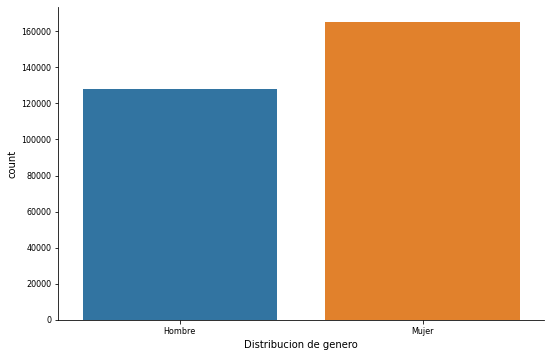

SEXO
Hombre    128023
Mujer     165124
Name: SEXO, dtype: int64

In [0]:
# Distribución de los datos por género
fg = sns.catplot('SEXO', data=df_eda, kind='count', aspect=1.5)
fg.set_xlabels('Distribucion de genero')
plt.show()
df_eda.groupby('SEXO')['SEXO'].count()

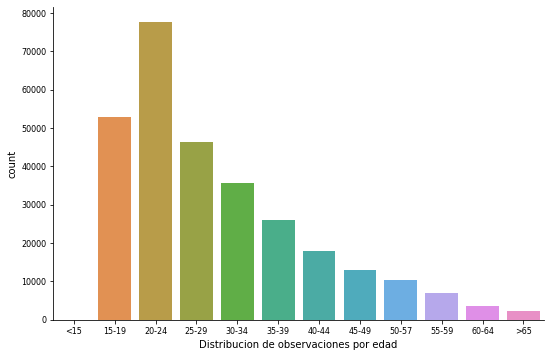

q
<15          0
15-19    52980
20-24    77674
25-29    46398
30-34    35701
35-39    25949
40-44    18007
45-49    13112
50-57    10480
55-59     6958
60-64     3478
>65       2410
Name: q, dtype: int64

In [0]:
# Distribución de los datos por edad
fg = sns.catplot('q', data=df_eda, kind='count', aspect=1.5)
fg.set_xlabels('Distribucion de observaciones por edad')
plt.show()
df_eda.groupby('q')['q'].count()

El siguiente gráfico, analiza cuatro variables:

  - SEXO: genero del estudiante
  - TOTAL_HRS: duración del curso
  - SUBSEC_PROGRAMA_actualizada: Subsectores de Programa
  - CALIFICA: calificación del estudiante
  
Del gráfico se puede apreciar como la mayoría de estudiantes matriculan cursos de menos de 200 horas de duración. Y aunque en todos los casos hay reprobados, pareciera que entre mayor duración de curso, mayor compromiso muestran los estudiantes, puesto que el gráfico hacia la derecha muestra que los estudiantes, o abandonaron el curso (obtuvieron una calificación de cero), o aprobaron el curso.

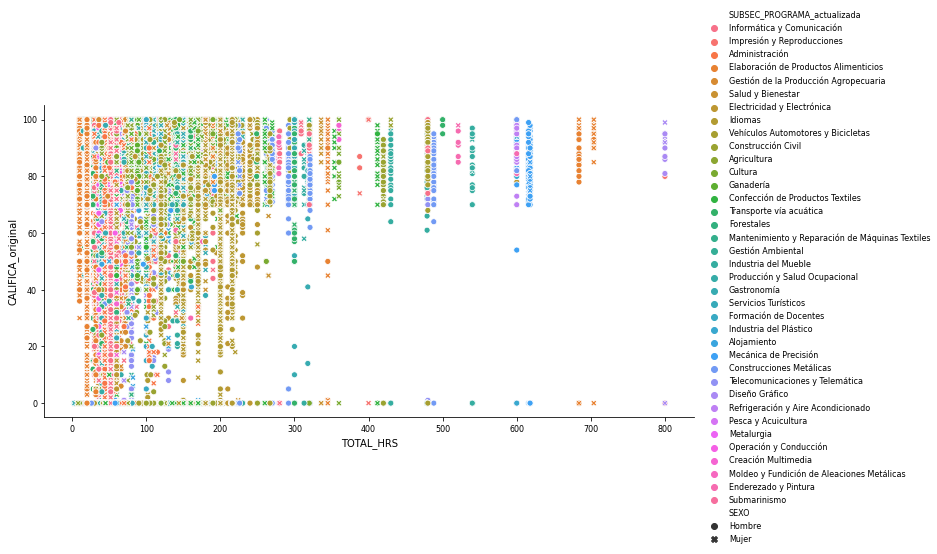

In [0]:
sns.relplot(x="TOTAL_HRS", y="CALIFICA_original", 
            hue='SUBSEC_PROGRAMA_actualizada', 
            style='SEXO', data=df_eda, aspect=2);

El siguiente diagrama de cajas, muestra lo que al parecer es un patrón en las edades de las personas que matriculan cursos en el INA:
 
 - Aquellos que carecen de estudios o que no terminaron la Primaria, son personas que cuyas edades van de 30 a 55 años aproximadamente.
 - Las personas con estudios secundarios o superiores incompletos al parecer están en sus 20s o a mitad de los 30s.
 - Las personas que terminaron sus estudios superiores, están en su mayoría entre el final de sus 20s y en los 30s.

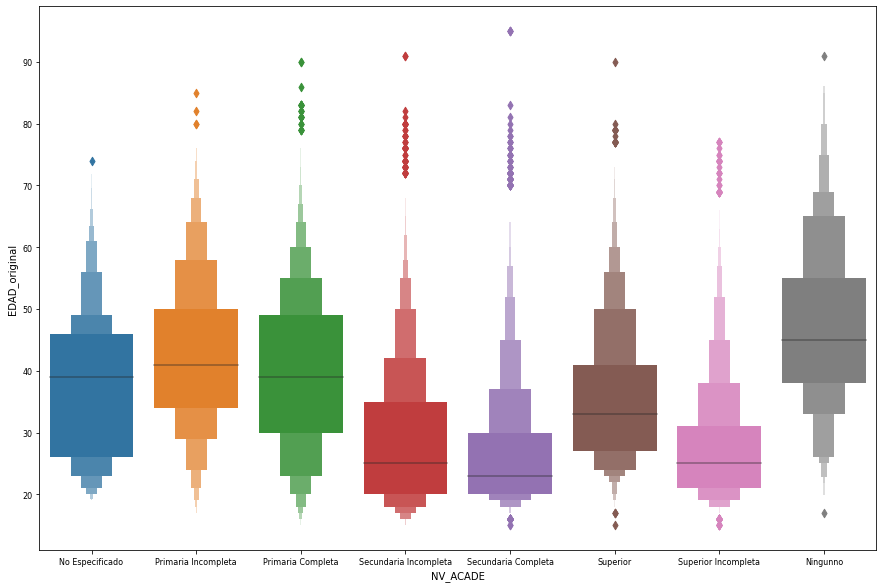

In [0]:
plt.figure(figsize=(15,10))
sns.boxenplot(y="EDAD_original", x="NV_ACADE", data=df_eda)

La siguiente distribución muestra que, sin importar la zona donde se del curso, la mayoría de estudiantes NO trabajan.

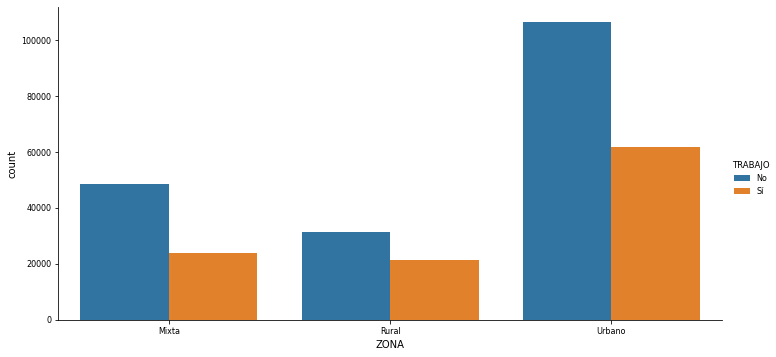

In [0]:
# Distribucion de personas que trabajan o no, por zona
sns.catplot('ZONA', data=df_eda, kind='count', hue='TRABAJO', aspect=2)

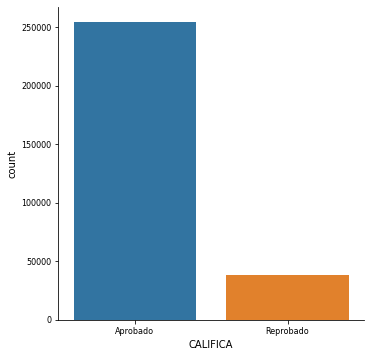

In [0]:
# Distribucion de observaciones de variable dependiente
sns.catplot('CALIFICA', data=df_eda, kind='count')

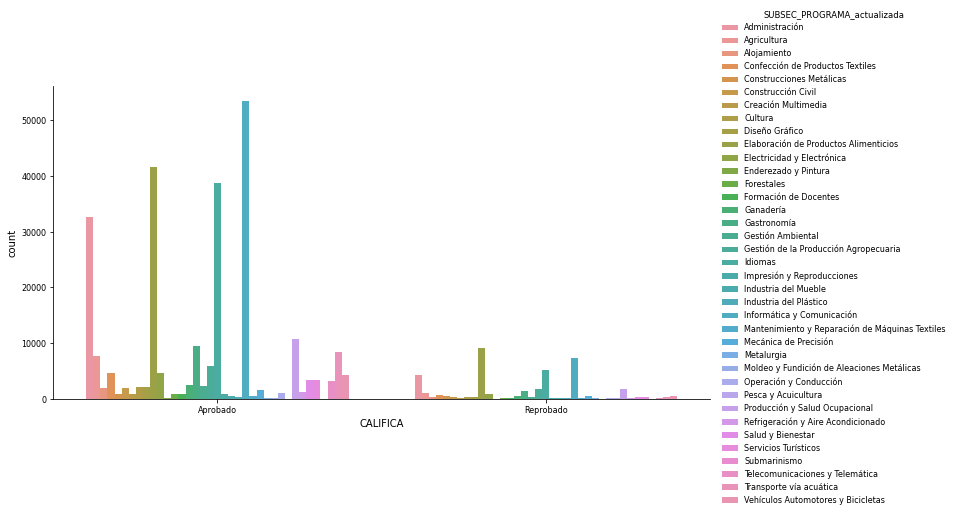

In [0]:
# Distribucion de observaciones por estado aprobado/reprobado y sub programa del curso
sns.catplot('CALIFICA', data=df_eda, hue='SUBSEC_PROGRAMA_actualizada', kind='count', aspect=2)

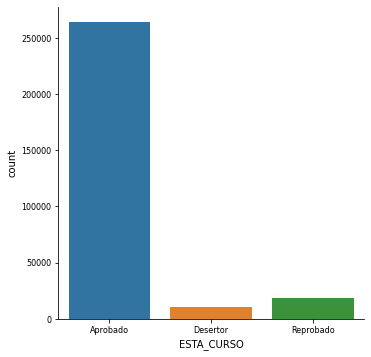

In [0]:
sns.catplot('ESTA_CURSO', data=df_eda, kind='count')

____________________

# Selección de variables(continuación)

In [0]:
def plot_correlation_matrix(data, font_size=14, width=20, height=20):
  # Code was base on this answer: https://stackoverflow.com/a/29432741
  f = plt.figure(figsize=(20, 20))
  plt.matshow(data.corr(), fignum=f.number)
  plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
  plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=14)

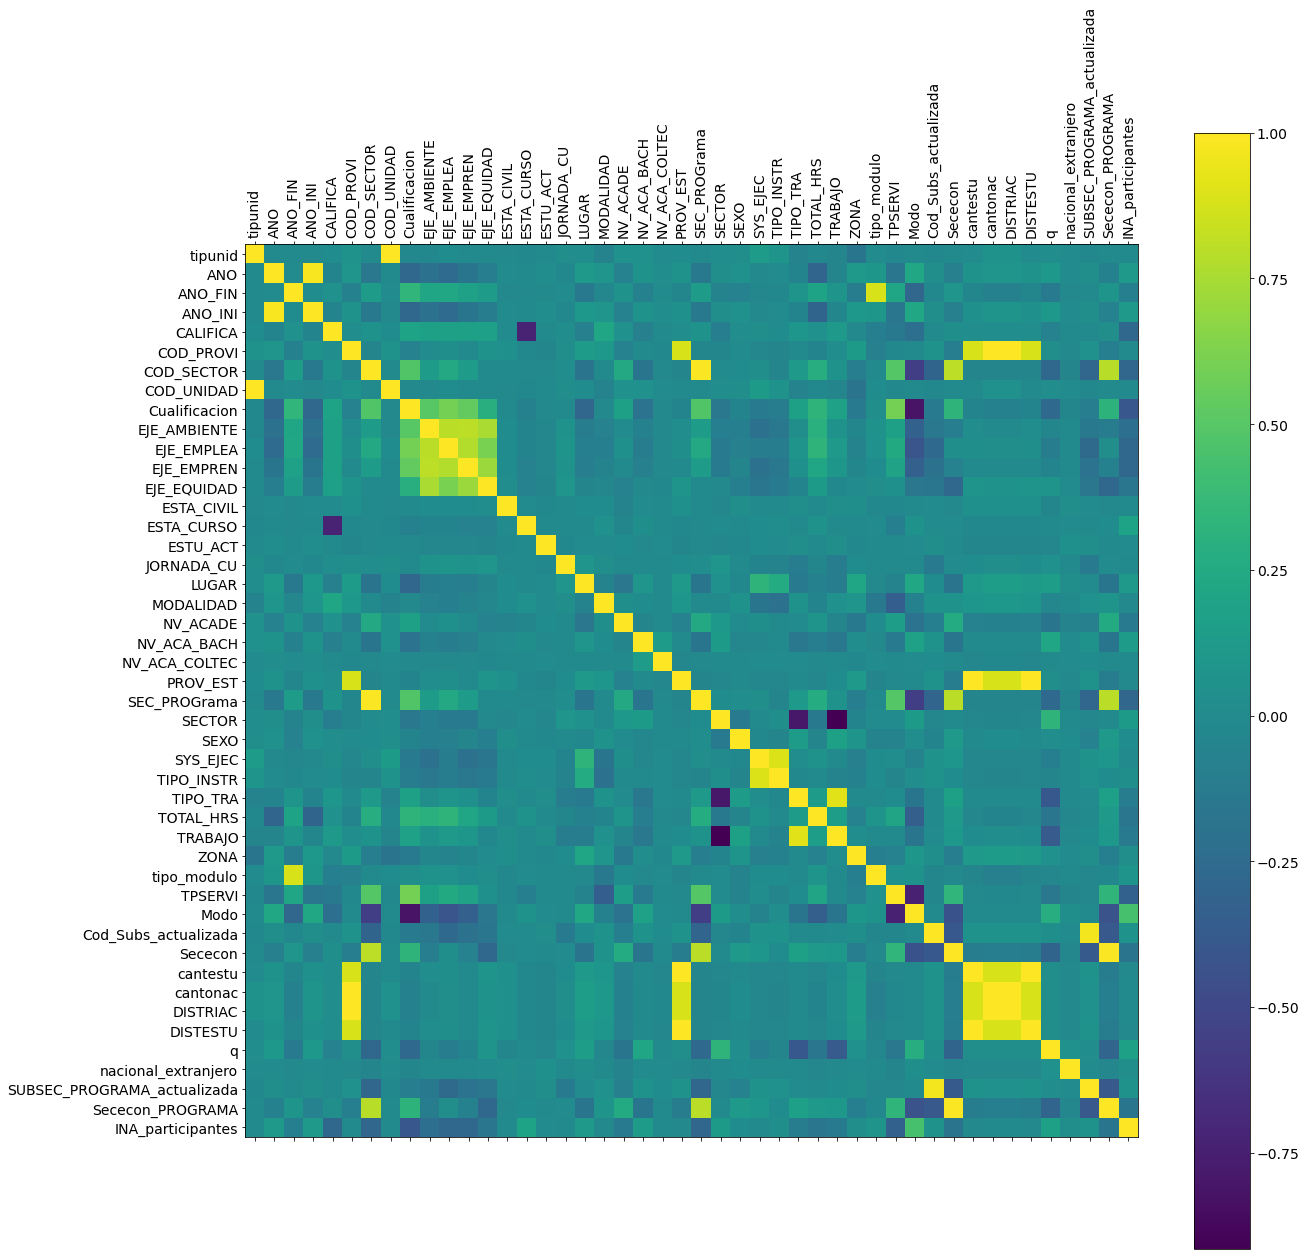

In [0]:
plot_correlation_matrix(df)

De la tabla de correlación, se determinaron otras variables a eliminar, puesto que pueden ser redundantes:

* ANO_INI
* COD_UNIDAD
* tipo_modulo
* COD_PROVI
* SEC_PROGrama
* cantestu
* cantonac
* DISTRIAC
* DISTESTU
* SUBSEC_PROGRAMA_actualizada
* Sesecon_PROGRAMA
* COD_SECTOR
* TRABAJO
* SYS_EJEC
* EJE_EMPLEA
* EJE_EMPREN

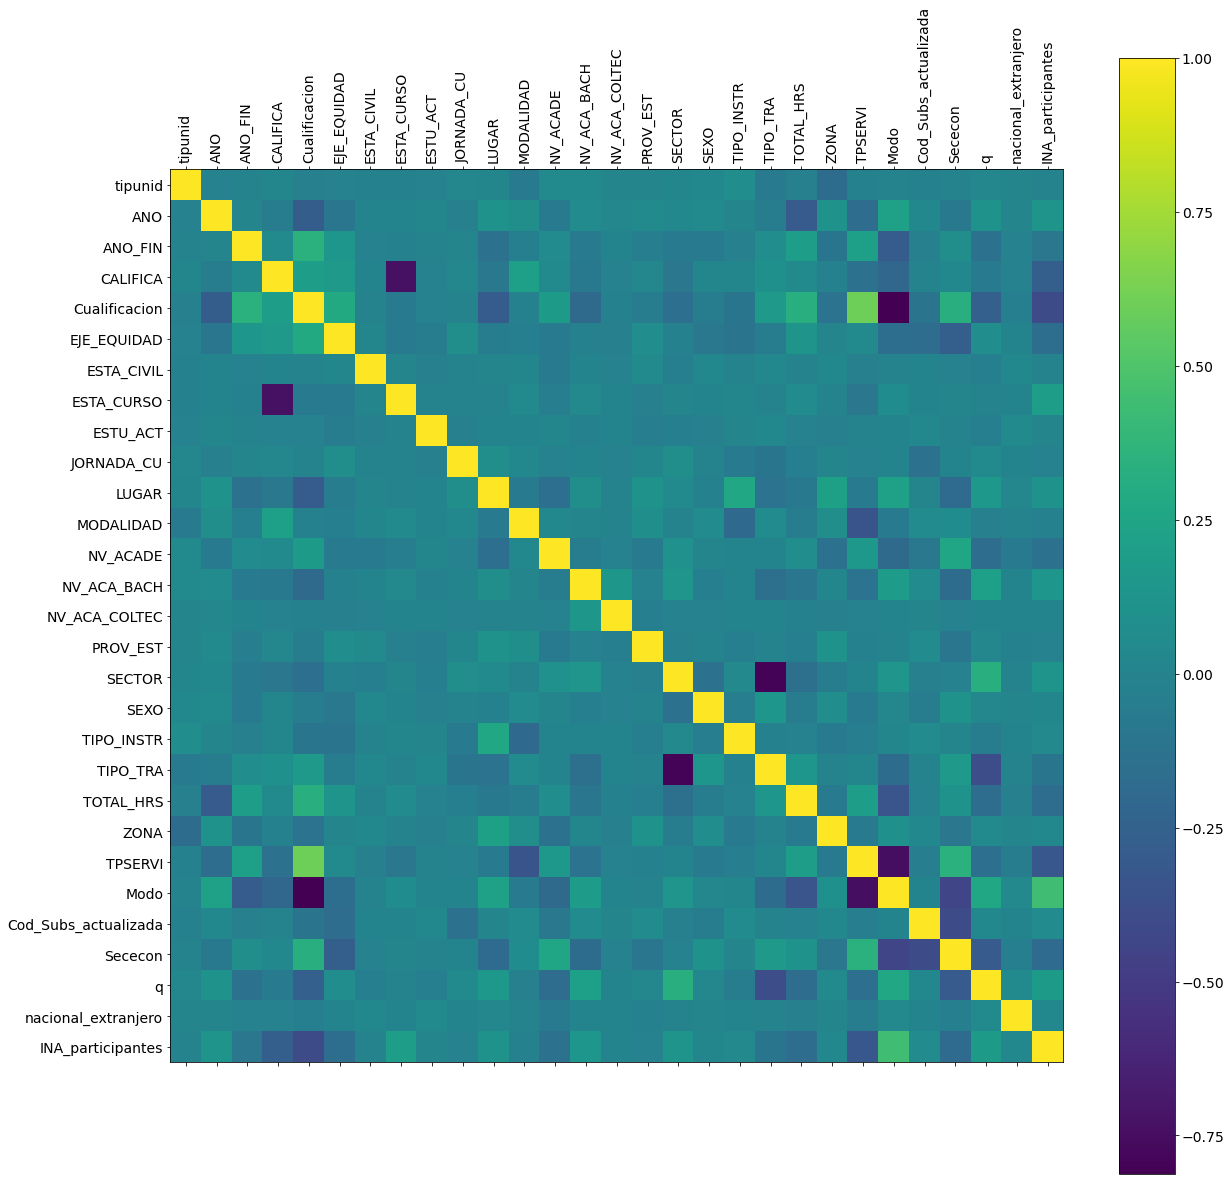

In [0]:
df.drop(['ANO_INI', 'COD_UNIDAD', 'tipo_modulo', 'COD_PROVI',  'SEC_PROGrama', 
         'cantestu', 'cantonac', 'DISTRIAC',  'DISTESTU', 'SUBSEC_PROGRAMA_actualizada', 
         'Sececon_PROGRAMA', 'COD_SECTOR', 'TRABAJO', 'EJE_EMPLEA', 'EJE_EMPREN',
         'EJE_AMBIENTE','SYS_EJEC'], inplace=True, axis=1)
plot_correlation_matrix(df)

Las siguientes columnas, si bien contienen valores números, corresponden a **factores nominales**, por lo que hay que "dummyficarlos", ya que un valor numérico alto en alguna de estas variables no significa que sea mayor que otro valor inferior.

In [0]:
variables_nominales = ['tipunid', 'Cualificacion', 'EJE_EQUIDAD','ESTA_CIVIL',
                       'ESTU_ACT','JORNADA_CU',
                       'LUGAR','MODALIDAD','NV_ACADE','NV_ACA_BACH','NV_ACA_COLTEC',
                       'PROV_EST','SECTOR','SEXO','TIPO_INSTR',
                       'TIPO_TRA','ZONA','TPSERVI','Modo',
                       'Cod_Subs_actualizada','Sececon', 'nacional_extranjero',
                       'INA_participantes',]

for col in variables_nominales:
  df[col] = df[col].astype('category')

print(len(df.columns))
df_expanded = pd.get_dummies(df, drop_first=True)
print(len(df_expanded.columns))
df_expanded

29
110


,ANO,ANO_FIN,CALIFICA,ESTA_CURSO,TOTAL_HRS,q,tipunid_2201,tipunid_2301,tipunid_2401,tipunid_2501,tipunid_2601,tipunid_2701,tipunid_2801,tipunid_2901,Cualificacion_2,Cualificacion_3,Cualificacion_4,EJE_EQUIDAD_1,ESTA_CIVIL_2,ESTA_CIVIL_3,ESTA_CIVIL_4,ESTA_CIVIL_5,ESTA_CIVIL_6,ESTA_CIVIL_7,ESTU_ACT_2,ESTU_ACT_3,ESTU_ACT_4,ESTU_ACT_5,ESTU_ACT_9,JORNADA_CU_2,JORNADA_CU_3,LUGAR_2,MODALIDAD_4,MODALIDAD_5,MODALIDAD_8,MODALIDAD_10,MODALIDAD_14,MODALIDAD_15,NV_ACADE_2,NV_ACADE_3,...,Cod_Subs_actualizada_24,Cod_Subs_actualizada_27,Cod_Subs_actualizada_28,Cod_Subs_actualizada_39,Cod_Subs_actualizada_40,Cod_Subs_actualizada_42,Cod_Subs_actualizada_44,Cod_Subs_actualizada_45,Cod_Subs_actualizada_56,Cod_Subs_actualizada_90,Cod_Subs_actualizada_95,Cod_Subs_actualizada_96,Cod_Subs_actualizada_97,Cod_Subs_actualizada_98,Cod_Subs_actualizada_99,Cod_Subs_actualizada_100,Cod_Subs_actualizada_102,Cod_Subs_actualizada_103,Cod_Subs_actualizada_104,Cod_Subs_actualizada_105,Cod_Subs_actualizada_106,Cod_Subs_actualizada_107,Cod_Subs_actualizada_108,Cod_Subs_actualizada_109,Cod_Subs_actualizada_110,Cod_Subs_actualizada_111,Cod_Subs_actualizada_112,Cod_Subs_actualizada_113,Cod_Subs_actualizada_114,Cod_Subs_actualizada_115,Cod_Subs_actualizada_116,Cod_Subs_actualizada_117,Cod_Subs_actualizada_118,Cod_Subs_actualizada_120,Cod_Subs_actualizada_121,Cod_Subs_actualizada_123,Sececon_2,Sececon_3,nacional_extranjero_2,INA_participantes_1
1,2018,2018,1,2,52.0,7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,2018,2018,1,2,52.0,7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,2018,2018,1,2,36.0,7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,2018,2018,1,2,52.0,7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
5,2018,2018,1,2,40.0,6,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300574,2018,2018,0,3,20.0,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
300575,2018,2018,1,2,20.0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
300576,2018,2018,1,2,20.0,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
300577,2018,2018,1,2,44.0,8,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


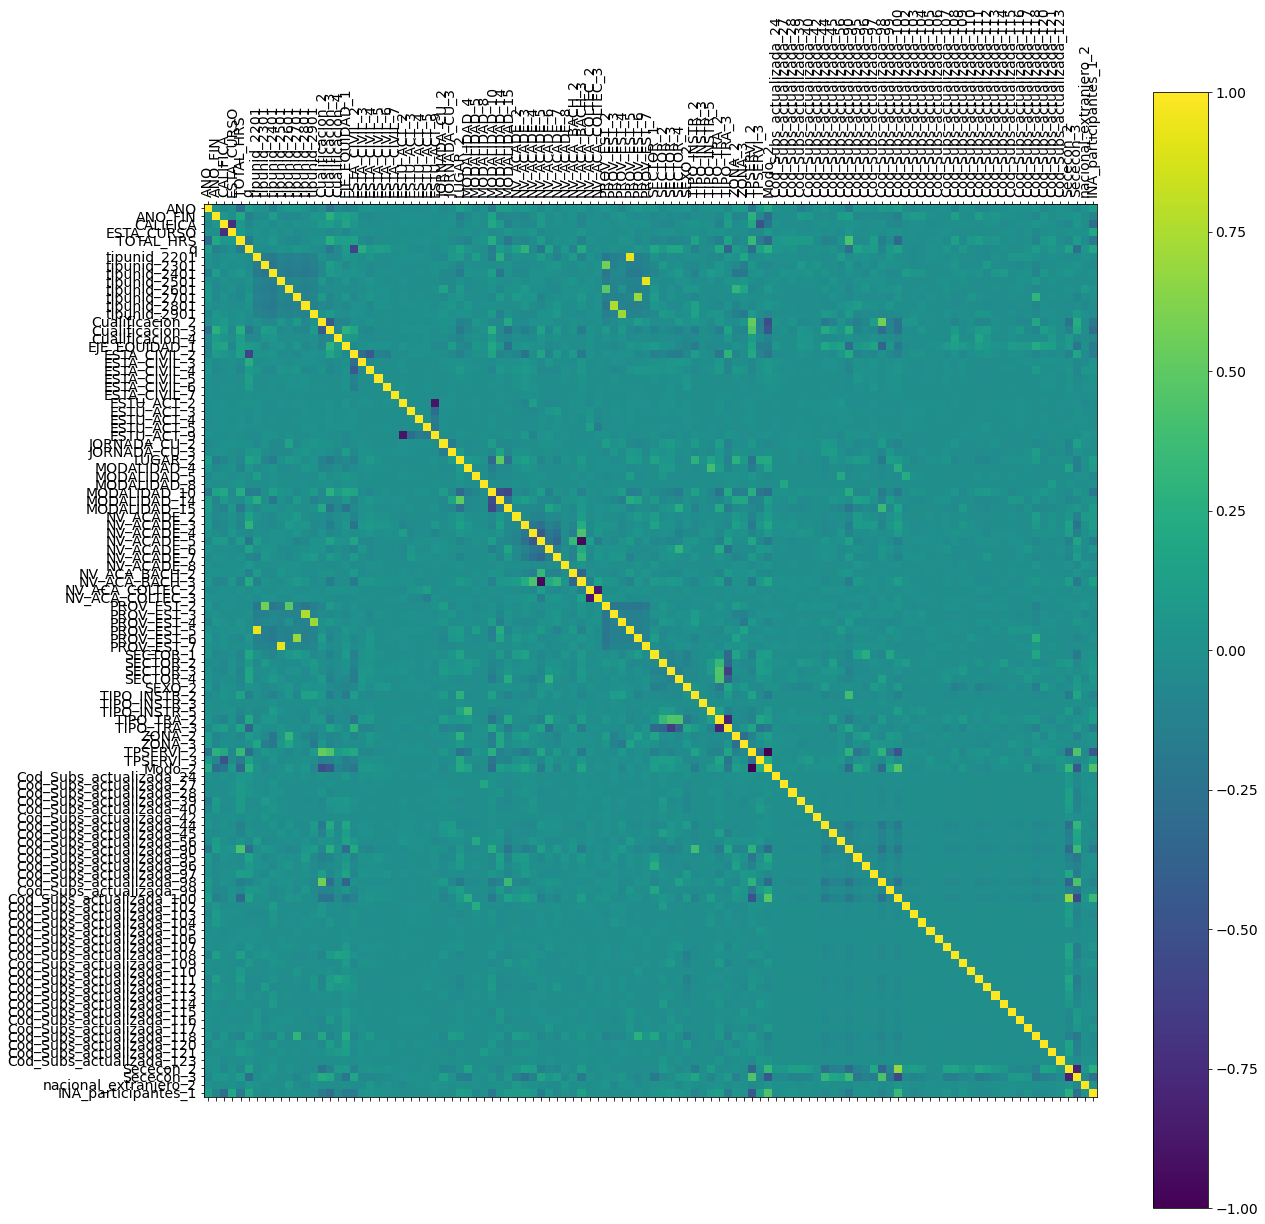

In [0]:
plot_correlation_matrix(df_expanded, font_size=8, width=50, height=50)

In [0]:
df_expanded.describe()

,ANO,ANO_FIN,CALIFICA,ESTA_CURSO,TOTAL_HRS,q,tipunid_2201,tipunid_2301,tipunid_2401,tipunid_2501,tipunid_2601,tipunid_2701,tipunid_2801,tipunid_2901,Cualificacion_2,Cualificacion_3,Cualificacion_4,EJE_EQUIDAD_1,ESTA_CIVIL_2,ESTA_CIVIL_3,ESTA_CIVIL_4,ESTA_CIVIL_5,ESTA_CIVIL_6,ESTA_CIVIL_7,ESTU_ACT_2,ESTU_ACT_3,ESTU_ACT_4,ESTU_ACT_5,ESTU_ACT_9,JORNADA_CU_2,JORNADA_CU_3,LUGAR_2,MODALIDAD_4,MODALIDAD_5,MODALIDAD_8,MODALIDAD_10,MODALIDAD_14,MODALIDAD_15,NV_ACADE_2,NV_ACADE_3,...,Cod_Subs_actualizada_24,Cod_Subs_actualizada_27,Cod_Subs_actualizada_28,Cod_Subs_actualizada_39,Cod_Subs_actualizada_40,Cod_Subs_actualizada_42,Cod_Subs_actualizada_44,Cod_Subs_actualizada_45,Cod_Subs_actualizada_56,Cod_Subs_actualizada_90,Cod_Subs_actualizada_95,Cod_Subs_actualizada_96,Cod_Subs_actualizada_97,Cod_Subs_actualizada_98,Cod_Subs_actualizada_99,Cod_Subs_actualizada_100,Cod_Subs_actualizada_102,Cod_Subs_actualizada_103,Cod_Subs_actualizada_104,Cod_Subs_actualizada_105,Cod_Subs_actualizada_106,Cod_Subs_actualizada_107,Cod_Subs_actualizada_108,Cod_Subs_actualizada_109,Cod_Subs_actualizada_110,Cod_Subs_actualizada_111,Cod_Subs_actualizada_112,Cod_Subs_actualizada_113,Cod_Subs_actualizada_114,Cod_Subs_actualizada_115,Cod_Subs_actualizada_116,Cod_Subs_actualizada_117,Cod_Subs_actualizada_118,Cod_Subs_actualizada_120,Cod_Subs_actualizada_121,Cod_Subs_actualizada_123,Sececon_2,Sececon_3,nacional_extranjero_2,INA_participantes_1
count,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,...,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000,293147.000000
mean,2017.870758,2018.138623,0.868070,2.171279,64.971969,4.505576,0.114263,0.151890,0.204177,0.071657,0.103296,0.087304,0.117061,0.082593,0.322060,0.264843,0.016057,0.356009,0.669507,0.038015,0.081174,0.004414,0.008924,0.000010,0.094386,0.010462,0.003128,0.004650,0.882990,0.070320,0.254156,0.368215,0.013577,0.004899,0.000314,0.572491,0.169686,0.197986,0.017633,0.100717,...,0.001972,0.001832,0.007027,0.007484,0.004418,0.000232,0.124501,0.045980,0.033986,0.158033,0.028501,0.009920,0.018233,0.208343,0.027177,0.173490,0.003613,0.006911,0.002753,0.000437,0.000109,0.012216,0.014252,0.003415,0.000532,0.017183,0.009650,0.003237,0.001569,0.006328,0.010681,0.003524,0.028914,0.011970,0.008699,0.000617,0.311305,0.591376,0.042119,0.412165
std,0.362750,0.371105,0.338416,0.599697,58.854277,2.309194,0.318132,0.358915,0.403100,0.257919,0.304346,0.282281,0.321493,0.275267,0.467267,0.441250,0.125694,0.478819,0.470391,0.191233,0.273103,0.066293,0.094044,0.003199,0.292366,0.101749,0.055842,0.068029,0.321432,0.255685,0.435386,0.482321,0.115726,0.069818,0.017713,0.494718,0.375358,0.398482,0.131613,0.300955,...,0.044360,0.042761,0.083533,0.086188,0.066318,0.015229,0.330152,0.209443,0.181194,0.364773,0.166400,0.099104,0.133794,0.406124,0.162601,0.378671,0.059996,0.082846,0.052396,0.020891,0.010447,0.109848,0.118529,0.058335,0.023062,0.129951,0.097762,0.056805,0.039582,0.079296,0.102794,0.059257,0.167565,0.108751,0.092860,0.024841,0.463028,0.4915

# Entrenamiento de modelos

**Objetivo**: Determinar si un estudiante aprobar o reprobar el curso que matriculó.

 - Variable dependiente: CALIFICA = 1 Aprobado, 0 Reprobado

Este es un problema de **clasificación**.

In [0]:
# Se elimina la variable dependiente, en este caso ESTA_CURSO es otra version de la variable que voy a predecir, por lo que la saco del dataset.
features = df_expanded.drop(['ESTA_CURSO', 'CALIFICA'], axis=1)
features

,ANO,ANO_FIN,TOTAL_HRS,q,tipunid_2201,tipunid_2301,tipunid_2401,tipunid_2501,tipunid_2601,tipunid_2701,tipunid_2801,tipunid_2901,Cualificacion_2,Cualificacion_3,Cualificacion_4,EJE_EQUIDAD_1,ESTA_CIVIL_2,ESTA_CIVIL_3,ESTA_CIVIL_4,ESTA_CIVIL_5,ESTA_CIVIL_6,ESTA_CIVIL_7,ESTU_ACT_2,ESTU_ACT_3,ESTU_ACT_4,ESTU_ACT_5,ESTU_ACT_9,JORNADA_CU_2,JORNADA_CU_3,LUGAR_2,MODALIDAD_4,MODALIDAD_5,MODALIDAD_8,MODALIDAD_10,MODALIDAD_14,MODALIDAD_15,NV_ACADE_2,NV_ACADE_3,NV_ACADE_4,NV_ACADE_5,...,Cod_Subs_actualizada_24,Cod_Subs_actualizada_27,Cod_Subs_actualizada_28,Cod_Subs_actualizada_39,Cod_Subs_actualizada_40,Cod_Subs_actualizada_42,Cod_Subs_actualizada_44,Cod_Subs_actualizada_45,Cod_Subs_actualizada_56,Cod_Subs_actualizada_90,Cod_Subs_actualizada_95,Cod_Subs_actualizada_96,Cod_Subs_actualizada_97,Cod_Subs_actualizada_98,Cod_Subs_actualizada_99,Cod_Subs_actualizada_100,Cod_Subs_actualizada_102,Cod_Subs_actualizada_103,Cod_Subs_actualizada_104,Cod_Subs_actualizada_105,Cod_Subs_actualizada_106,Cod_Subs_actualizada_107,Cod_Subs_actualizada_108,Cod_Subs_actualizada_109,Cod_Subs_actualizada_110,Cod_Subs_actualizada_111,Cod_Subs_actualizada_112,Cod_Subs_actualizada_113,Cod_Subs_actualizada_114,Cod_Subs_actualizada_115,Cod_Subs_actualizada_116,Cod_Subs_actualizada_117,Cod_Subs_actualizada_118,Cod_Subs_actualizada_120,Cod_Subs_actualizada_121,Cod_Subs_actualizada_123,Sececon_2,Sececon_3,nacional_extranjero_2,INA_participantes_1
1,2018,2018,52.0,7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,2018,2018,52.0,7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,2018,2018,36.0,7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,2018,2018,52.0,7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
5,2018,2018,40.0,6,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300574,2018,2018,20.0,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
300575,2018,2018,20.0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
300576,2018,2018,20.0,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
300577,2018,2018,44.0,8,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


In [0]:
depVar = df_expanded['CALIFICA']
depVar

1         1
2         1
3         1
4         1
5         1
         ..
300574    0
300575    1
300576    1
300577    1
300578    1
Name: CALIFICA, Length: 293147, dtype: int64

In [0]:
# división de datos en test y set
X_train, X_test, y_train, y_test = train_test_split(features, depVar, 
                                                    test_size=0.30, 
                                                    random_state=192128)

In [0]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(205202, 108) (87945, 108) (205202,) (87945,)


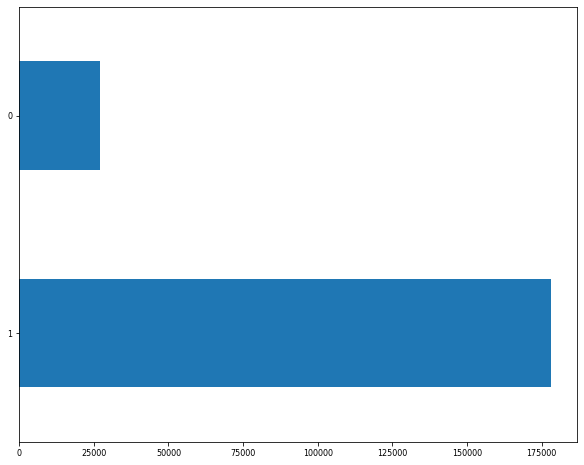

In [0]:
y_train.value_counts().plot(kind='barh')

In [0]:
#Models
modelRC = RandomForestClassifier(n_jobs=-1)
modelDTC = DecisionTreeClassifier()

models = [modelRC, modelDTC]

In [0]:
def trainModels(models, X, y):
  for model in models:
    model.fit(X, y)

In [0]:
trainModels(models, X_train, y_train)
for model in models:
  print(model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [0]:
def scoreModels(model_list, Xtrain, ytrain, Xtest, ytest, scoringMethod='r2'):
  for model in model_list:
    print(f"Model type: {type(model)}")
    scores = cross_val_score(model, Xtrain, ytrain, scoring=scoringMethod)
    print(scores)
    print(model.score(Xtest, ytest))

In [0]:
scoreModels(models, X_train, y_train, X_test, y_test, 'accuracy')

Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0.90429083 0.90092834 0.90146199 0.90336257 0.90168129]
0.904724543748934
Model type: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
[0.87368729 0.8701055  0.87039474 0.87178363 0.86956628]
0.873352663596566


#### Pruebas con algunas redes neuronales

In [0]:
from sklearn.neural_network import MLPClassifier
clf1 = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(5, 2),
                    max_iter=3000,
                    random_state=4384153)
clf1.fit(X_train, y_train)

clf2 = MLPClassifier(solver='sgd', 
                     alpha=1e-5,
                     hidden_layer_sizes=(5, 2), 
                     shuffle=True,
                     max_iter=3000,
                     random_state=4384153)
clf2.fit(X_train, y_train)

clf3 = MLPClassifier(solver='adam', 
                     alpha=1e-5,
                     hidden_layer_sizes=(5, 2), 
                     shuffle=True,
                     max_iter=3000,
                     random_state=4384153)
clf3.fit(X_train, y_train)


scoreModels([clf1, clf2, clf3], X_train, y_train, X_test, y_test, 'accuracy')

Model type: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
[0.86735216 0.86735216 0.86737329 0.86737329 0.86737329]
0.8697140258115867
Model type: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
[0.86735216 0.86735216 0.86737329 0.86737329 0.86737329]
0.8697140258115867
Model type: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
[0.86735216 0.86735216 0.86737329 0.86737329 0.86737329]
0.8697140258115867


### Análisis de resultados

El modelo que tuvo la mejor precisión fue el RandomForestClassifier, con una métrica de 0.90429. Se va a utilizar este modelo para realizar las predicciones y evaluar con el set de datos de validación.


In [0]:
selected_model = modelRC
predictions = selected_model.predict(X_test)
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.45      0.55     11458
           1       0.92      0.97      0.95     76487

    accuracy                           0.90     87945
   macro avg       0.82      0.71      0.75     87945
weighted avg       0.89      0.90      0.90     87945



Matriz de confución
[[0.05913923 0.07114674]
 [0.02412872 0.84558531]]


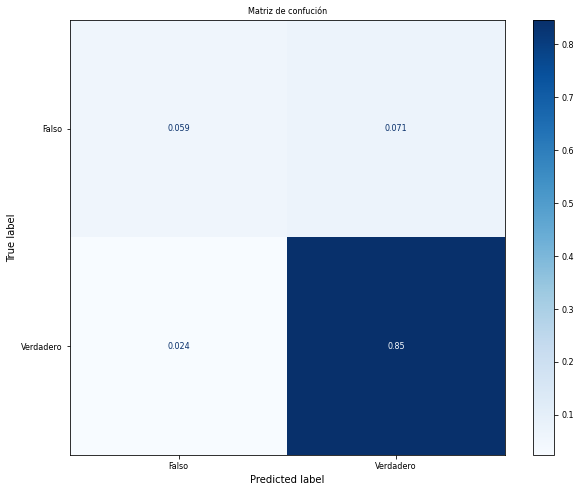

In [0]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(selected_model, X_test, y_test, 
                             display_labels=['Falso', 'Verdadero'],
                             cmap=plt.cm.Blues,
                             normalize='all')
title = "Matriz de confución"
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)

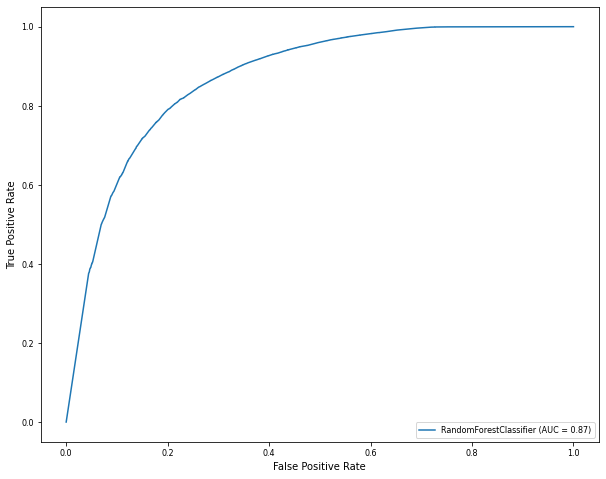

In [0]:
from sklearn.metrics import plot_roc_curve
svc_disp = plot_roc_curve(selected_model, X_test, y_test)
title = "Curva ROC"
disp.ax_.set_title(title)
plt.show()